## Тестовое задание (аналитик-разработчик)

### Описание проекта

В таблице «исходные данные.xlsx» содержатся исторические данные по агрегированным показателям активности клиентов. Ежемесячно с помощью ряда сложных бизнес-правил и экспертных решений производится присвоение определенной категории клиенту (число от 0 до 10). 
В таблице с исходными данными содержатся значения соответствующей категории (столбец «Категория клиента через месяц»)
Требуется предсказать категории для нового списка клиентов, для которых ежемесячное оценивание ещё не проходило (таблица «новые данные.xlsx»).
В качестве решения необходимо предоставить файл Excel с единственным столбцом – предположительным значением категории для соответствующего клиента (клиенты в том же порядке, что и в файле «новые данные.xlsx»). Кроме того, необходимо предоставить небольшой отчёт, описывающий процесс решения и обоснование полученного результата. Желательно, если Вы также самостоятельно оцените точность полученного предсказания.


### Шаг 1. Загрузим данные

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [ ]:
stock = pd.read_csv('stock.csv', encoding= 'Windows-1251', sep=';')
new = pd.read_csv('new.csv', encoding= 'Windows-1251', sep=';')

Получим общую информацию о данных:

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Кол-во негаб. накладных          4872 non-null   int64  
 1   Кол-во логинов на сайт ДЛ        4872 non-null   int64  
 2   Коэф. лояльности                 4872 non-null   float64
 3   Средний процент скидки           4872 non-null   float64
 4   Доля экспресс-доставки           4872 non-null   float64
 5   Среднее кол-во накладных в мес.  4872 non-null   int64  
 6   Средний оборот                   4872 non-null   int64  
 7   Доля доставки до адреса          4872 non-null   float64
 8   Коэф-т отзывчивости              4872 non-null   float64
 9   Коэф. разнообразия типов услуг   4872 non-null   float64
 10  Среднее кол-во жалоб             4872 non-null   int64  
 11  ОПФ                              4872 non-null   object 
 12  Категория клиента че

In [ ]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625 entries, 0 to 1624
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Кол-во негаб. накладных          1625 non-null   int64  
 1   Кол-во логинов на сайт ДЛ        1625 non-null   int64  
 2   Коэф. лояльности                 1625 non-null   float64
 3   Средний процент скидки           1625 non-null   float64
 4   Доля экспресс-доставки           1625 non-null   float64
 5   Среднее кол-во накладных в мес.  1625 non-null   int64  
 6   Средний оборот                   1625 non-null   int64  
 7   Доля доставки до адреса          1625 non-null   float64
 8   Коэф-т отзывчивости              1625 non-null   float64
 9   Коэф. разнообразия типов услуг   1625 non-null   float64
 10  Среднее кол-во жалоб             1625 non-null   int64  
 11  ОПФ                              1625 non-null   object 
dtypes: float64(6), int64

In [ ]:
# <Преобразуем категориальный столбец "ОПФ" в бинарный: 0 - ЮЛ, 1 - ФЛ>
stock['ОПФ'] = stock['ОПФ'].replace('ЮЛ', 0)
stock['ОПФ'] = stock['ОПФ'].replace('ФЛ', 1)
new['ОПФ'] = new['ОПФ'].replace('ЮЛ', 0)
new['ОПФ'] = new['ОПФ'].replace('ФЛ', 1)

Построим матрицу корреляций и отобразим её:

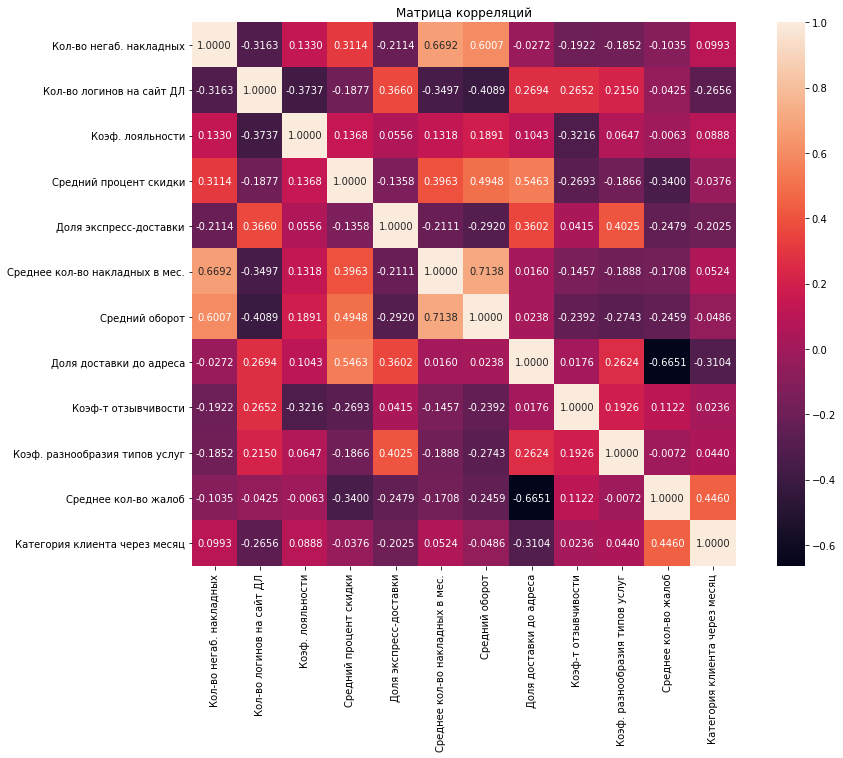

In [ ]:
# корреляционная матрица
corr_m = stock.corr()

# нарисуем heatmap
plt.figure(figsize=(15, 10))
plt.title('Матрица корреляций')
sns.heatmap(corr_m, annot=True, square = True, fmt='.4f')

Судя по матрице корреляций почти все признаки слабо коррелируют между собой. Сильнее всего коррелирует "Средний оборот" с "Средним кол-вом накладных в месяц"

### Шаг 2. Построим модель прогнозирования

Разделим наши данные на признаки (матрица X) и целевую переменную (y):

In [ ]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = stock.drop('Категория клиента через месяц', axis = 1) 
y = stock['Категория клиента через месяц']

Далее разделим модель на обучающую и тестовую выборку (в соотношение 80% на 20%):

In [ ]:
# разделим модель на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизируем данные:

In [ ]:
# Стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Обучим модель на train-выборке тремя способами: методом k ближайших соседей (kNN), градиентного бустинга (gbt) и моделью случайного леса (rf):

In [ ]:
# kNN – метод ближайших соседей
# Обучим модель:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

# Сделаем прогноз:
knn_train_predict = knn.predict(X_train)
knn_test_predict = knn.predict(X_test)

# GBT – градиентный бустинг деревьев решений
# Обучим модель:
from sklearn import ensemble
gbt = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
gbt.fit(X_train, y_train)

# Random Forest – случайный лес
# Обучим модель:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

Теперь проверим точность прогноза:

In [ ]:
# Посчитаем точность:
knn_train = accuracy_score(y_train, knn_train_predict)
knn_test = accuracy_score(y_test, knn_test_predict)

gbt_train = accuracy_score(y_train, gbt.predict(X_train))
gbt_test = accuracy_score(y_test, gbt.predict(X_test))

rf_train = accuracy_score(y_train, rf.predict(X_train))
rf_test = accuracy_score(y_test, rf.predict(X_test))

print("knn:", knn_train, knn_test)
print("gbt:",gbt_train, gbt_test)
print("rf:", rf_train, rf_test)

knn: 1.0 0.5907692307692308
gbt: 0.7146522966384399 0.5692307692307692
rf: 1.0 0.6451282051282051


Как видим наилучшая точность прогноза получилась по моделе случайного леса. По тестовой выборке она составила **64,5%**

Посчитаем важность каждого признака с помощью алгоритма случайного леса. Чем больше число, тем значимее признак. Сумма всех чисел равна 1.

In [ ]:
feature_names = stock.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Важность признаков:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Важность признаков:
 1. feature 'Доля доставки до адреса' (0.1267)
 2. feature 'Средний оборот' (0.1164)
 3. feature 'Доля экспресс-доставки' (0.1108)
 4. feature 'Коэф. разнообразия типов услуг' (0.1094)
 5. feature 'Средний процент скидки' (0.1072)
 6. feature 'Коэф-т отзывчивости' (0.1046)
 7. feature 'Коэф. лояльности' (0.1028)
 8. feature 'Среднее кол-во жалоб' (0.0744)
 9. feature 'Кол-во логинов на сайт ДЛ' (0.0706)
10. feature 'Среднее кол-во накладных в мес.' (0.0492)
11. feature 'Кол-во негаб. накладных' (0.0229)
12. feature 'ОПФ  ' (0.0051)


Построим диаграмму:

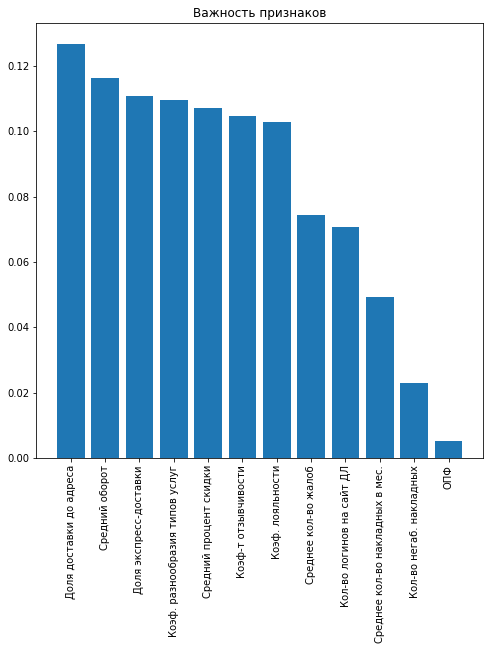

In [ ]:
d_first = 12
plt.figure(figsize=(8, 8))
plt.title("Важность признаков")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

Наименее важным признакмами являются "Кол-во негаб. накладных" и "ОПФ"

### Шаг 3. Предсказание категорий

In [ ]:
# Стандартизируем данные
scaler.fit(new)
new_cat = scaler.transform(new)

# Сделаем прогноз:
new_cat_predict = rf.predict(new_cat)

# сохраняем метки кластера в поле нашего датасета
new['Категория клиента через месяц'] = new_cat_predict

Выведем средние значения признаков по категорям для новый клиентов:

In [ ]:
# выводим статистику по средним значениям наших признаков по кластеру
new.groupby(['Категория клиента через месяц']).mean().T.round(3)

Категория клиента через месяц,4,5,6,7,8
Кол-во негаб. накладных,2.200,2.480,2.483,2.542,2.684
Кол-во логинов на сайт ДЛ,6.200,5.740,4.107,3.833,3.474
Коэф. лояльности,0.132,0.307,0.322,0.332,0.317
Средний процент скидки,0.022,0.060,0.052,0.051,0.076
Доля экспресс-доставки,0.058,0.069,0.050,0.045,0.045
Среднее кол-во накладных в мес.,2.200,3.629,3.491,3.526,4.053
Средний оборот,202000.000,249453.629,227443.593,227281.250,255105.263
Доля доставки до адреса,0.694,0.696,0.694,0.693,0.694
Коэф-т отзывчивости,3.204,3.204,3.221,3.212,3.156
Коэф. разнообразия типов услуг,0.448,0.523,0.522,0.555,0.461


Выведем средние значения признаков по категорям для старых клиентов:

In [ ]:
# выводим статистику по средним значениям наших признаков по кластеру
stock.groupby(['Категория клиента через месяц']).mean().T.round(3)

Категория клиента через месяц,3,4,5,6,7,8,9
Кол-во негаб. накладных,2.091,1.969,2.431,2.491,2.513,2.559,3.000
Кол-во логинов на сайт ДЛ,7.955,6.401,5.383,4.256,3.885,3.862,4.000
Коэф. лояльности,0.275,0.267,0.308,0.324,0.336,0.332,0.370
Средний процент скидки,0.052,0.040,0.058,0.056,0.046,0.055,0.025
Доля экспресс-доставки,0.090,0.057,0.066,0.054,0.046,0.041,0.026
Среднее кол-во накладных в мес.,3.955,2.432,3.484,3.558,3.444,3.876,4.000
Средний оборот,231772.727,206586.420,241394.885,230978.843,211411.619,236875.862,228000.000
Доля доставки до адреса,0.696,0.695,0.696,0.695,0.693,0.693,0.690
Коэф-т отзывчивости,3.254,3.242,3.212,3.220,3.231,3.226,3.335
Коэф. разнообразия типов услуг,0.542,0.499,0.529,0.532,0.553,0.522,0.467


Сохраним категории и таблицу с клиентам в файл Excel

In [ ]:
category= pd.DataFrame(new['Категория клиента через месяц'])
category.to_excel('category.xlsx', index = False)

final = pd.DataFrame(new_cat_predict)
final.to_excel('final.xlsx', index = False)